In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club (2015) to predict the state of a loan given some information about it. You can download the dataset [here](https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1)

In [2]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    'https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1',
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
y2015.head()

id   member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68009401  72868139.0    16000.0      16000.0          16000.0   60 months   
1  68354783  73244544.0     9600.0       9600.0           9600.0   36 months   
2  68466916  73356753.0    25000.0      25000.0          25000.0   36 months   
3  68466961  73356799.0    28000.0      28000.0          28000.0   36 months   
4  68495092  73384866.0     8650.0       8650.0           8650.0   36 months   

  int_rate  installment grade sub_grade  ... num_tl_90g_dpd_24m  \
0   14.85%       379.39     C        C5  ...                0.0   
1    7.49%       298.58     A        A4  ...                0.0   
2    7.49%       777.55     A        A4  ...                0.0   
3    6.49%       858.05     A        A2  ...                0.0   
4   19.89%       320.99     E        E3  ...                0.0   

  num_tl_op_past_12m pct_tl_nvr_dlq  percent_bc_gt_75 pub_rec_bankruptcies  \
0                2.0           78.9               0.0                  0.0   
1                2.0          100.0              66.7                  0.0   
2                0.0          100.0              20.0                  0.0   
3                0.0           91.7              22.2                  0.0   
4               12.0          100.0              50.0                  1.0   

  tax_liens tot_hi_cred_lim total_bal_ex_mort total_bc_limit  \
0       2.0        298100.0           31329.0       281300.0   
1       0.0         88635.0           55387.0        12500.0   
2       0.0        373572.0           68056.0        38400.0   
3       0.0        304003.0           74920.0        41500.0   
4       0.0         38998.0           18926.0         2750.0   

  total_il_high_credit_limit  
0                    13400.0  
1                    75635.0  
2                    82117.0  
3                    42503.0  
4                    18248.0  

[5 rows x 111 columns]

In [4]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [5]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

Wonder what was causing the dtype error on the id column, which _should_ have all been integers? Let's look at the end of the file.

In [6]:
y2015.tail()

id   member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
421092  36271333.0  38982739.0    13000.0      13000.0          13000.0   
421093  36490806.0  39222577.0    12000.0      12000.0          12000.0   
421094  36271262.0  38982659.0    20000.0      20000.0          20000.0   
421095         NaN         NaN        NaN          NaN              NaN   
421096         NaN         NaN        NaN          NaN              NaN   

              term  int_rate  installment grade emp_length  ...  \
421092   60 months     15.99       316.07     D    5 years  ...   
421093   60 months     19.99       317.86     E     1 year  ...   
421094   36 months     11.99       664.20     B  10+ years  ...   
421095         NaN       NaN          NaN   NaN        NaN  ...   
421096         NaN       NaN          NaN   NaN        NaN  ...   

       num_tl_90g_dpd_24m  num_tl_op_past_12m pct_tl_nvr_dlq percent_bc_gt_75  \
421092                0.0                 3.0          100.0             50.0   
421093                1.0                 2.0           95.0             66.7   
421094                0.0                 1.0          100.0             50.0   
421095                NaN                 NaN            NaN              NaN   
421096                NaN                 NaN            NaN              NaN   

       pub_rec_bankruptcies tax_liens tot_hi_cred_lim total_bal_ex_mort  \
421092                  1.0       0.0         51239.0           34178.0   
421093                  0.0       0.0         96919.0           58418.0   
421094                  0.0       1.0         43740.0           33307.0   
421095                  NaN       NaN             NaN               NaN   
421096                  NaN       NaN             NaN               NaN   

        total_bc_limit  total_il_high_credit_limit  
421092         10600.0                     33239.0  
421093          9700.0                     69919.0  
421094         41700.0                         0.0  
421095             NaN                         NaN  
421096             NaN                         NaN  

[5 rows x 103 columns]

In [7]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

In [8]:
y2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Columns: 103 entries, id to total_il_high_credit_limit
dtypes: float64(87), object(16)
memory usage: 330.9+ MB


In [9]:
non_numeric_columns = y2015.select_dtypes(['object']).columns
numeric_columns = y2015.select_dtypes(['float64']).columns

num_percent_missing = (y2015[numeric_columns].isnull().sum()/y2015[numeric_columns].isnull().count()).sort_values(ascending=False)
print(num_percent_missing)

dti_joint               0.998791
annual_inc_joint        0.998786
il_util                 0.955789
mths_since_rcnt_il      0.950581
open_acc_6m             0.949247
                          ...   
acc_open_past_24mths    0.000000
total_rev_hi_lim        0.000000
total_bc_limit          0.000000
tot_cur_bal             0.000000
id                      0.000000
Length: 87, dtype: float64


In [10]:
missing_atleast_25percent = num_percent_missing[num_percent_missing >= .25]
print(missing_atleast_25percent)

dti_joint                         0.998791
annual_inc_joint                  0.998786
il_util                           0.955789
mths_since_rcnt_il                0.950581
open_acc_6m                       0.949247
open_il_6m                        0.949247
open_il_12m                       0.949247
open_il_24m                       0.949247
total_bal_il                      0.949247
open_rv_12m                       0.949247
max_bal_bc                        0.949247
all_util                          0.949247
inq_fi                            0.949247
total_cu_tl                       0.949247
inq_last_12m                      0.949247
open_rv_24m                       0.949247
mths_since_last_record            0.823282
mths_since_recent_bc_dlq          0.742101
mths_since_last_major_derog       0.708548
mths_since_recent_revol_delinq    0.639661
mths_since_last_delinq            0.484361
dtype: float64


In [11]:
y2015.drop(['dti_joint', 'annual_inc_joint', 'il_util', 'mths_since_rcnt_il', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'total_bal_il', 'open_rv_12m', 'max_bal_bc', 'all_util', 'inq_fi','total_cu_tl', 'inq_last_12m', 'open_rv_24m', 'mths_since_last_record', 'mths_since_recent_bc_dlq','mths_since_last_major_derog', 'mths_since_recent_revol_delinq', 'mths_since_last_delinq', 'verification_status_joint'], 1, inplace=True)
y2015.head()

id   member_id  loan_amnt  funded_amnt  funded_amnt_inv  \
0  68009401.0  72868139.0    16000.0      16000.0          16000.0   
1  68354783.0  73244544.0     9600.0       9600.0           9600.0   
2  68466916.0  73356753.0    25000.0      25000.0          25000.0   
3  68466961.0  73356799.0    28000.0      28000.0          28000.0   
4  68495092.0  73384866.0     8650.0       8650.0           8650.0   

         term  int_rate  installment grade emp_length  ... num_tl_90g_dpd_24m  \
0   60 months     14.85       379.39     C  10+ years  ...                0.0   
1   36 months      7.49       298.58     A    8 years  ...                0.0   
2   36 months      7.49       777.55     A  10+ years  ...                0.0   
3   36 months      6.49       858.05     A  10+ years  ...                0.0   
4   36 months     19.89       320.99     E    8 years  ...                0.0   

   num_tl_op_past_12m pct_tl_nvr_dlq percent_bc_gt_75 pub_rec_bankruptcies  \
0                 2.0           78.9              0.0                  0.0   
1                 2.0          100.0             66.7                  0.0   
2                 0.0          100.0             20.0                  0.0   
3                 0.0           91.7             22.2                  0.0   
4                12.0          100.0             50.0                  1.0   

  tax_liens tot_hi_cred_lim total_bal_ex_mort  total_bc_limit  \
0       2.0        298100.0           31329.0        281300.0   
1       0.0         88635.0           55387.0         12500.0   
2       0.0        373572.0           68056.0         38400.0   
3       0.0        304003.0           74920.0         41500.0   
4       0.0         38998.0           18926.0          2750.0   

   total_il_high_credit_limit  
0                     13400.0  
1                     75635.0  
2                     82117.0  
3                     42503.0  
4                     18248.0  

[5 rows x 81 columns]

In [12]:
y2015.loan_status.unique()

array(['Current', 'Fully Paid', 'Charged Off', 'Late (31-120 days)',
       'In Grace Period', 'Default', 'Late (16-30 days)'], dtype=object)

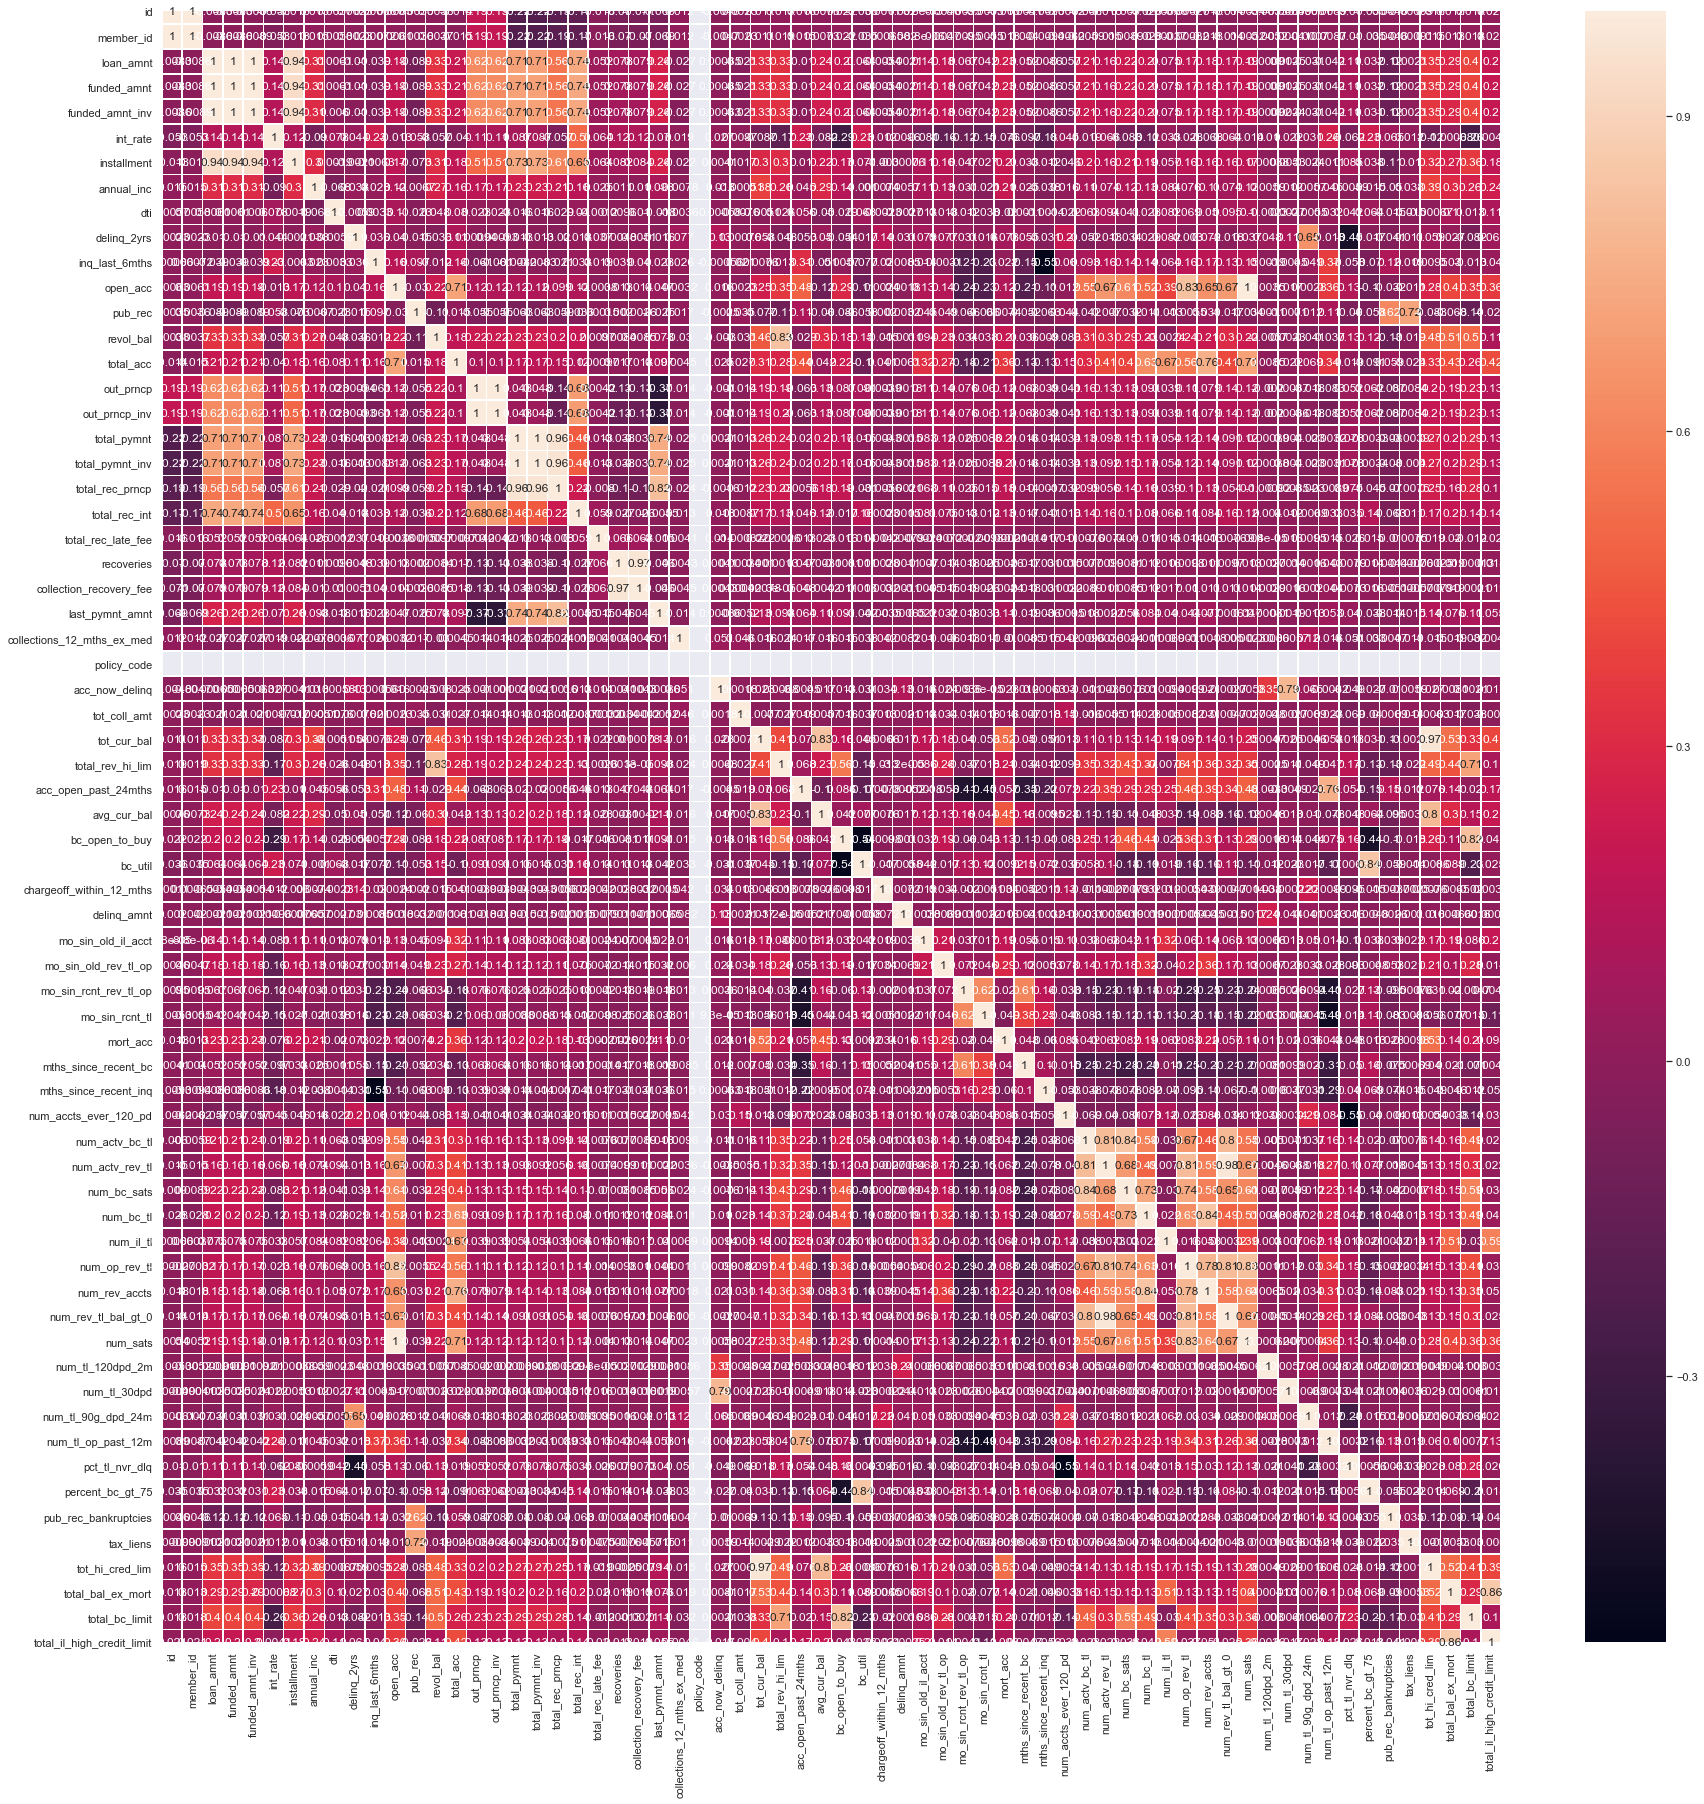

In [13]:
import seaborn as sns
corrmat_y2015 = y2015.corr()

sns.set()
f, ax = plt.subplots(figsize=(30,30))
sns.heatmap(corrmat_y2015, annot=True, linewidths=.5, ax=ax)
plt.show()

In [14]:
# Create correlation matrix
corr_matrix = y2015.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

# Drop features 
y2015.drop(y2015[to_drop], axis=1, inplace=True)

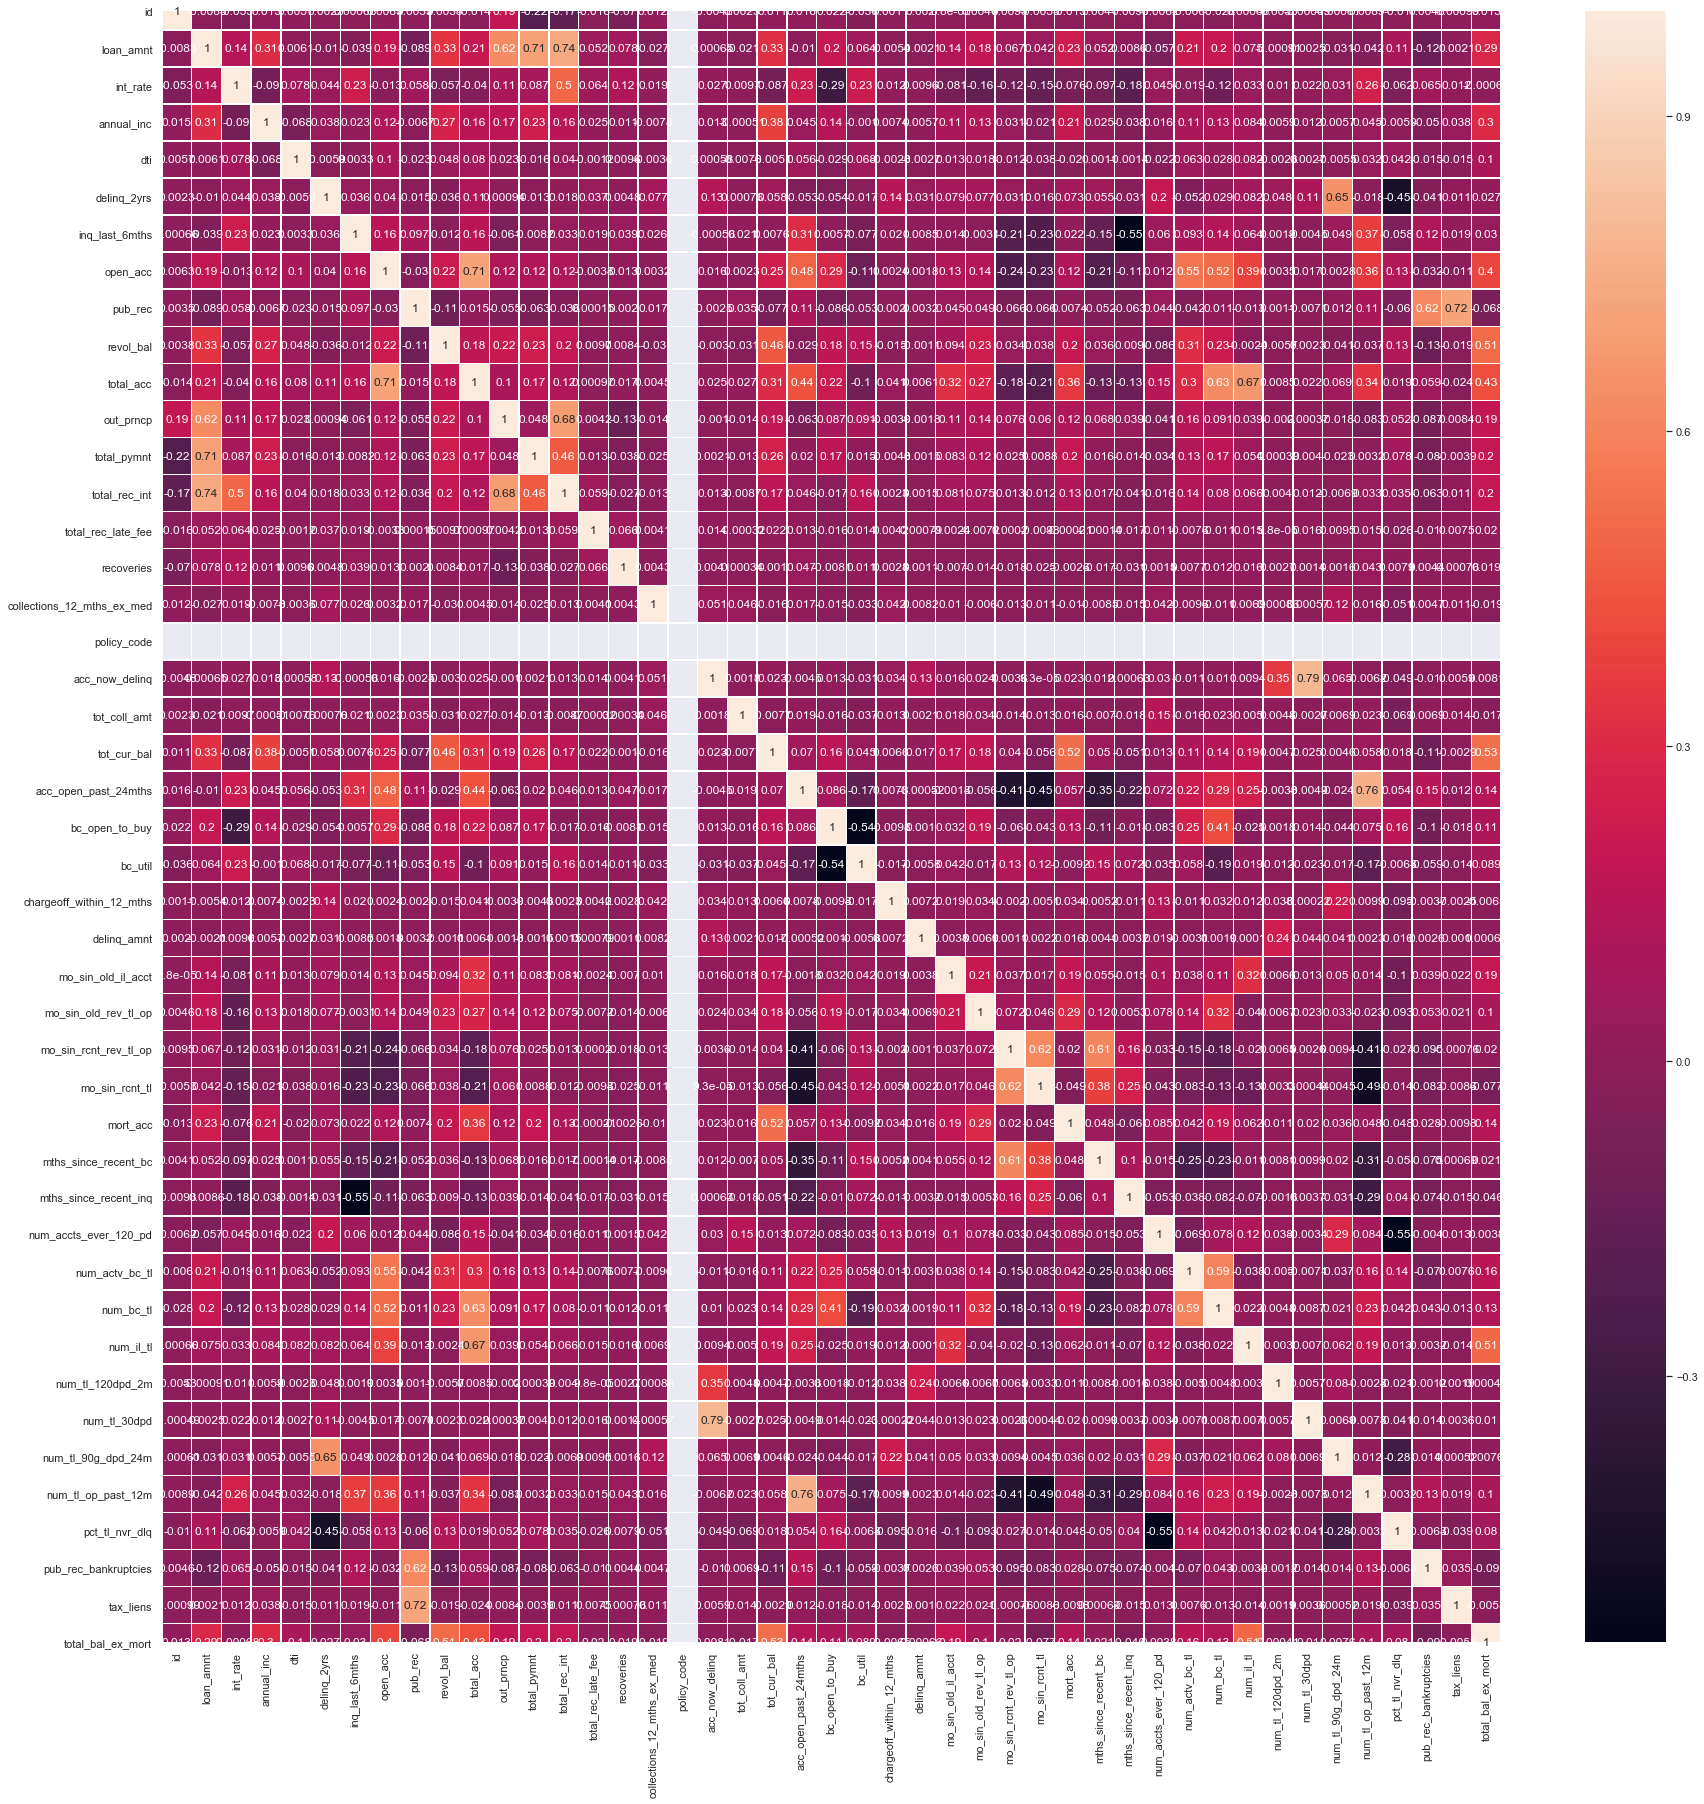

In [15]:
corrmat_y2015 = y2015.corr()

sns.set()
f, ax = plt.subplots(figsize=(30,30))
sns.heatmap(corrmat_y2015, annot=True, linewidths=.5, ax=ax)
plt.show()

In [16]:
y2015.policy_code.unique()

array([1.])

In [17]:
y2015.drop(['policy_code'], 1, inplace=True)

In [18]:
y2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Data columns (total 59 columns):
id                            421095 non-null float64
loan_amnt                     421095 non-null float64
term                          421095 non-null object
int_rate                      421095 non-null float64
grade                         421095 non-null object
emp_length                    397278 non-null object
home_ownership                421095 non-null object
annual_inc                    421095 non-null float64
verification_status           421095 non-null object
issue_d                       421095 non-null object
loan_status                   421095 non-null object
pymnt_plan                    421095 non-null object
purpose                       421095 non-null object
title                         420963 non-null object
dti                           421095 non-null float64
delinq_2yrs                   421095 non-null float64
inq_last_6mths                42109

In [19]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

term
2
grade
7
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
purpose
14
title
27
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2


In [20]:
X = y2015.drop('loan_status', 1)
X = X.dropna(axis=1)
X = pd.get_dummies(X)

In [21]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.80
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

# Drop features 
X.drop(X[to_drop], axis=1, inplace=True)

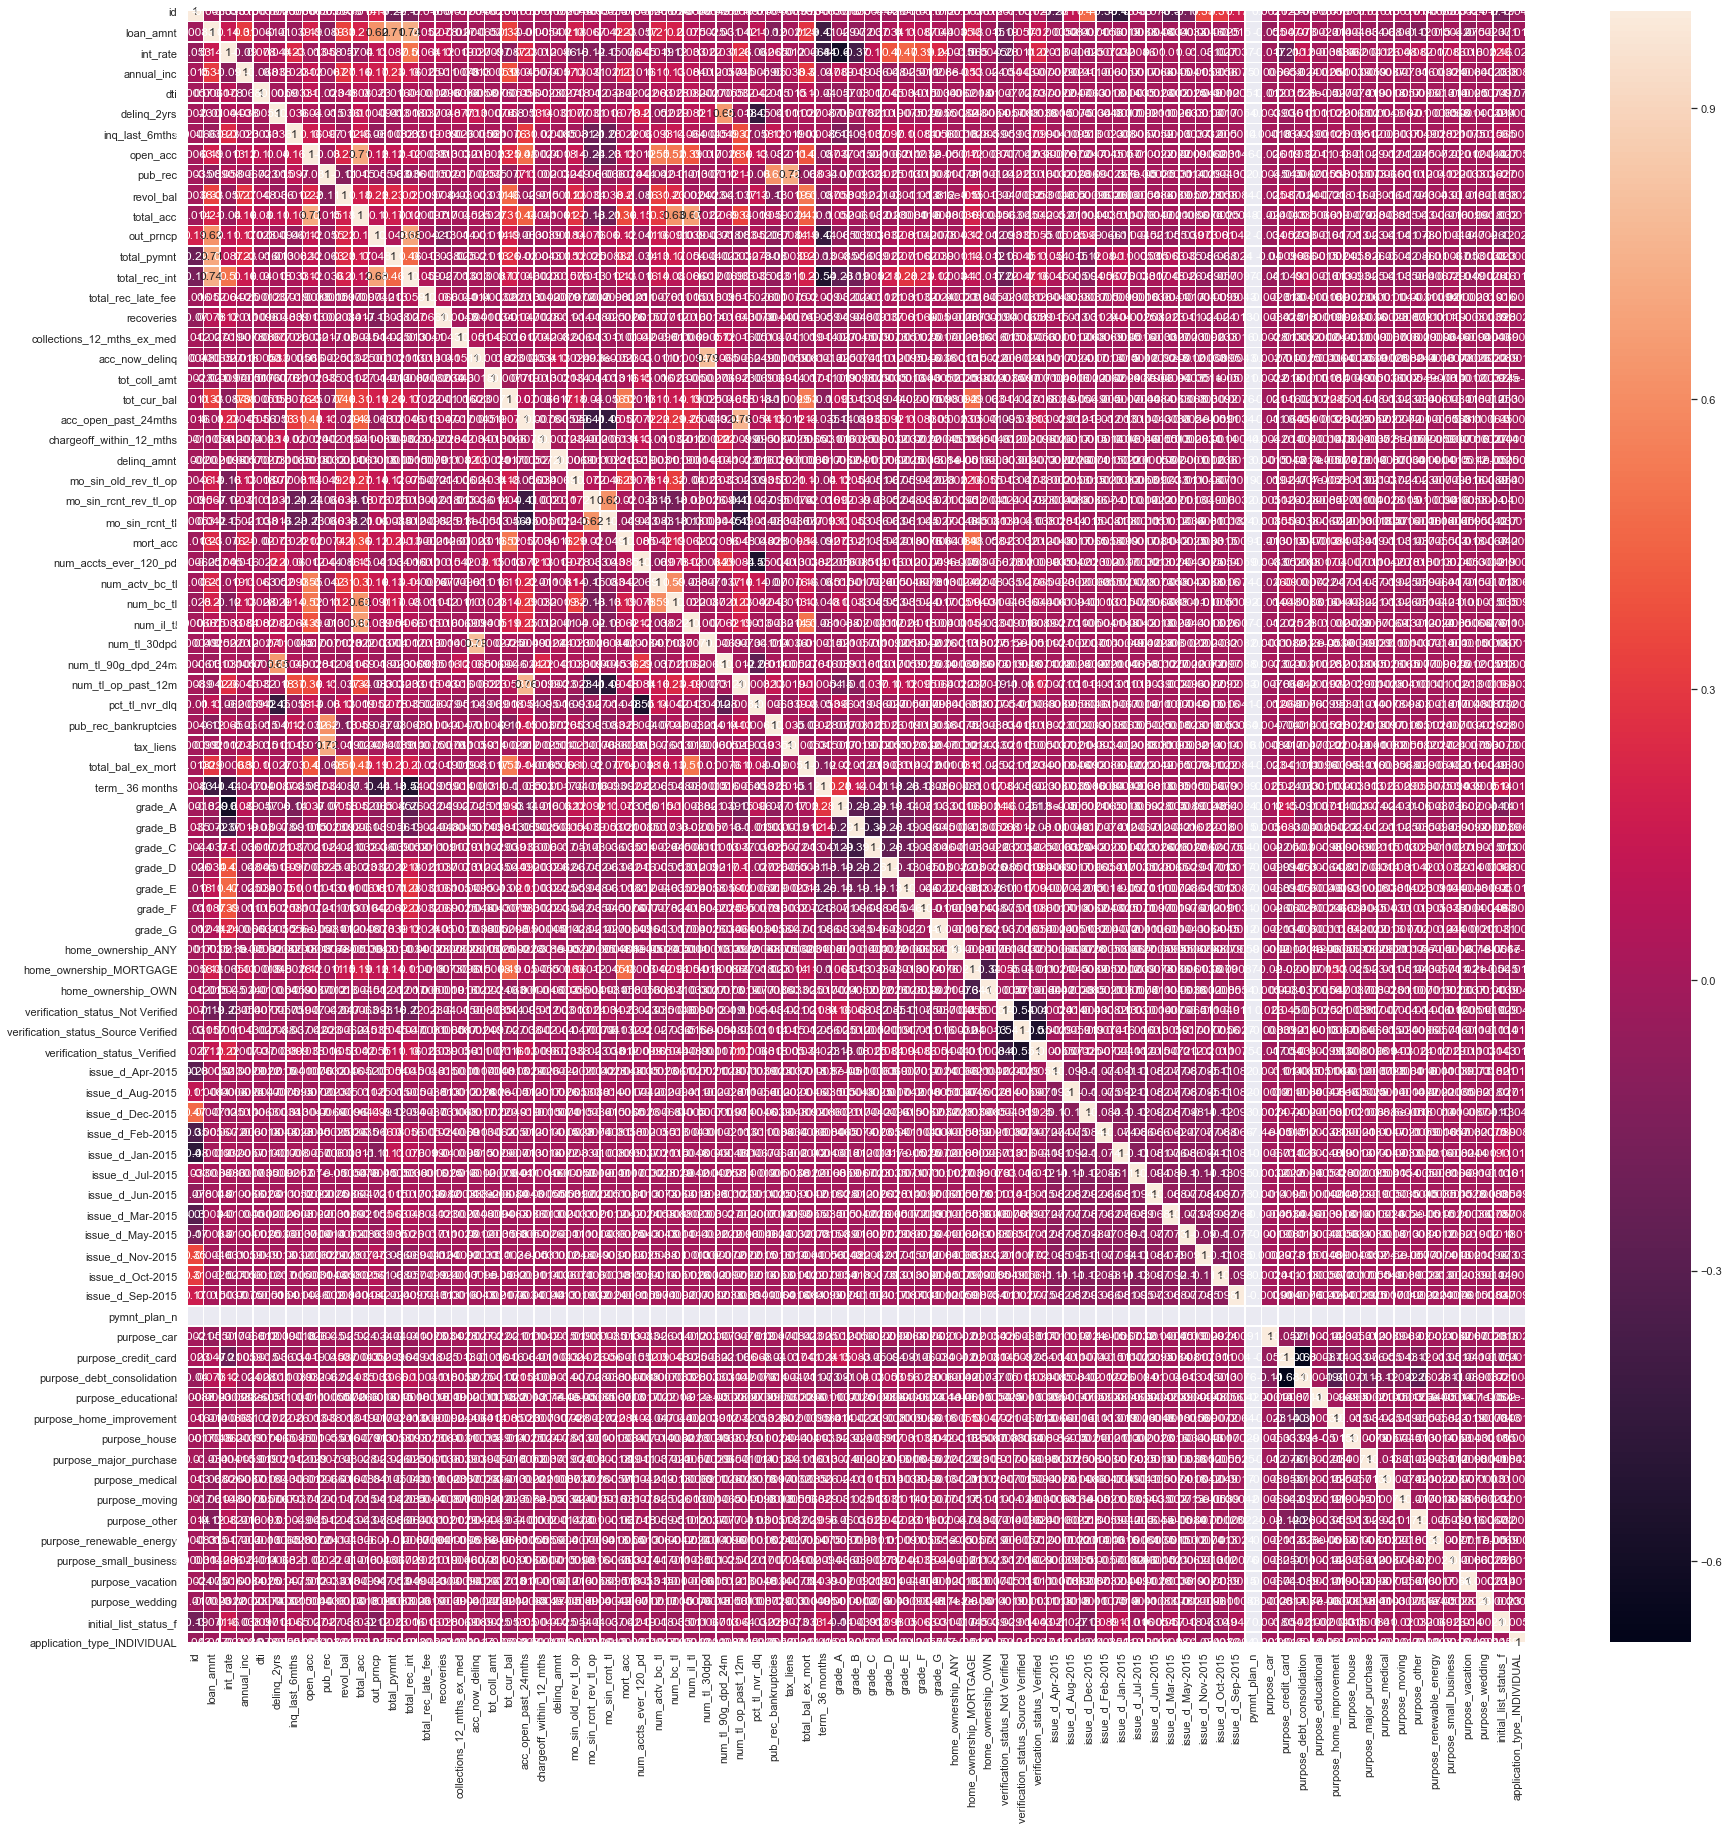

In [22]:
corrmat_X = X.corr()

sns.set()
f, ax = plt.subplots(figsize=(30,30))
sns.heatmap(corrmat_X, annot=True, linewidths=.5, ax=ax)
plt.show()

In [26]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
Y = y2015['loan_status']

cross_val_score(rfc, X, Y, cv=10)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: F

array([0.95017929, 0.95711334, 0.95343259, 0.95141412, 0.95051057,
       0.95008312, 0.83737443, 0.95447529, 0.95224072, 0.9487959 ])

It finally works! We had to sacrifice sub grade, state address and description, but that's fine. If you want to include them you could run the dummies independently and then append them back to the dataframe.

## Second Attempt

Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [25]:
# Your code here.

